### Load mat data

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

In [4]:
mat_contents = sio.loadmat('/Users/dalin/Documents/My_Research/Dataset/ALM_Svoboda_Lab_Data/Code/TLDS/TempDat/Simultaneous_Spikes.mat')

In [106]:
nDataSet = mat_contents['nDataSet']
params = mat_contents['params']

In [110]:
params['timeSeries'].flatten()

array([array([[-3.09973046, -3.03234501, -2.96495957, -2.89757412, -2.83018868,
        -2.76280323, -2.69541779, -2.62803235, -2.5606469 , -2.49326146,
        -2.42587601, -2.35849057, -2.29110512, -2.22371968, -2.15633423,
        -2.08894879, -2.02156334, -1.9541779 , -1.88679245, -1.81940701,
        -1.75202156, -1.68463612, -1.61725067, -1.54986523, -1.48247978,
        -1.41509434, -1.34770889, -1.28032345, -1.21293801, -1.14555256,
        -1.07816712, -1.01078167, -0.94339623, -0.87601078, -0.80862534,
        -0.74123989, -0.67385445, -0.606469  , -0.53908356, -0.47169811,
        -0.40431267, -0.33692722, -0.26954178, -0.20215633, -0.13477089,
        -0.06738544,  0.        ,  0.06738544,  0.13477089,  0.20215633,
         0.26954178,  0.33692722,  0.40431267,  0.47169811,  0.53908356,
         0.606469  ,  0.67385445,  0.74123989,  0.80862534,  0.87601078,
         0.94339623,  1.01078167,  1.07816712,  1.14555256,  1.21293801,
         1.28032345,  1.34770889,  1.4150943

In [44]:
nDataSet[0, 0][0].flatten()[0] # sessionIndex
nDataSet[0, 0][1].flatten() # nUnit
nDataSet[0, 0][2] # unitROCIndex
nDataSet[0, 0][3].flatten() # unit_yes_trial_index
nDataSet[0, 0][4].flatten() # unit_no_trial_index
nDataSet[0, 0][5] # unit_yes_trial, trial x unit x Time
nDataSet[0, 0][6] # unit_no_trial, trial x unit x Time
nDataSet[0, 0][7].flatten() # totTargets
nDataSet[0, 0][8].flatten() # firstLickTime

array([181.832,  88.666, 148.   ,  85.833, 100.666, 135.491,  75.333,
        84.167,  75.333, 105.166,  90.499, 125.166,  71.666,  51.333,
        90.833,  77.667, 120.333, 139.833, 103.833,  95.833, 136.499,
       113.499, 111.166,  67.166, 180.499, 105.5  , 117.5  ,  85.666,
        75.333, 137.999,  76.833, 107.999,  91.5  ,  86.999, 100.833,
        65.667, 141.666,  96.996,  59.833, 137.832, 114.833,  80.5  ,
       106.499, 104.166, 190.333, 110.166,  68.5  ])

In [48]:
nSession = 17 # matlab index
nSession = nSession - 1
totTargets = nDataSet[0, nSession][7].flatten()
unit_yes_trial = nDataSet[0, nSession][5]
unit_no_trial = nDataSet[0, nSession][6]

In [77]:
from pybasicbayes.util.text import progprint_xrange
from pylds.util import random_rotation
from pyslds.models import DefaultSLDS
import numpy.random as npr

In [73]:
unit_trial = np.concatenate((unit_yes_trial, unit_no_trial))
numTrial, numUnit, numTime = unit_trial.shape
unit_trial = unit_trial.transpose([0, 2, 1])
unit_trial = unit_trial.reshape([-1, unit_trial.shape[2]])

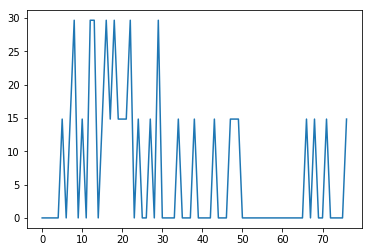

In [74]:
# plt.plot(unit_trial[:, 8].reshape(numTrial, numTime)[40,:])

In [75]:
# transition
K = 8
yDim = numUnit
xDim = 5
inputDim = 1 # some constants

In [78]:
test_model = DefaultSLDS(K, yDim, xDim, inputDim,
                         Cs=npr.randn(yDim, xDim),
                         Ds=npr.randn(yDim, inputDim))

In [79]:
inputs = np.ones((numTrial * numTime, inputDim))

In [81]:
test_model.add_data(unit_trial, inputs=inputs)

In [82]:
print("Initializing with Gibbs")
N_gibbs_samples = 1000
def initialize(model):
    model.resample_model()
    return model.log_likelihood()

gibbs_lls = [initialize(test_model) for _ in progprint_xrange(N_gibbs_samples)]

Initializing with Gibbs
.........................  [   25/1000,    0.11sec avg, ETA 01:50 ]
.........................  [   50/1000,    0.11sec avg, ETA 01:46 ]
.........................  [   75/1000,    0.11sec avg, ETA 01:43 ]
.........................  [  100/1000,    0.11sec avg, ETA 01:41 ]
.........................  [  125/1000,    0.11sec avg, ETA 01:38 ]
.........................  [  150/1000,    0.11sec avg, ETA 01:35 ]
.........................  [  175/1000,    0.11sec avg, ETA 01:32 ]
.........................  [  200/1000,    0.11sec avg, ETA 01:29 ]
.........................  [  225/1000,    0.11sec avg, ETA 01:26 ]
.........................  [  250/1000,    0.11sec avg, ETA 01:23 ]
.........................  [  275/1000,    0.11sec avg, ETA 01:20 ]
.........................  [  300/1000,    0.11sec avg, ETA 01:17 ]
.........................  [  325/1000,    0.11sec avg, ETA 01:15 ]
.........................  [  350/1000,    0.11sec avg, ETA 01:12 ]
........................

In [83]:
# Fit with VBEM
print("Fitting with VBEM")
N_vbem_iters = 1000
def update(model):
    model.VBEM_step()
    return model.log_likelihood()

test_model.states_list[0]._init_mf_from_gibbs()
vbem_lls = [update(test_model) for _ in progprint_xrange(N_vbem_iters)]

Fitting with VBEM
.........................  [   25/1000,    0.22sec avg, ETA 03:33 ]
....................

/Users/dalin/anaconda/envs/py2/lib/python2.7/site-packages/pyhsmm/internals/hmm_states.py:675: RuntimeWarning: divide by zero encountered in log
  np.log(trans_potential),likelihood_log_potential,alphal,betal,


.....  [   50/1000,    0.22sec avg, ETA 03:26 ]
.........................  [   75/1000,    0.22sec avg, ETA 03:19 ]
.........................  [  100/1000,    0.22sec avg, ETA 03:15 ]
.........................  [  125/1000,    0.22sec avg, ETA 03:09 ]
.........................  [  150/1000,    0.21sec avg, ETA 03:02 ]
.........................  [  175/1000,    0.21sec avg, ETA 02:56 ]
.........................  [  200/1000,    0.21sec avg, ETA 02:51 ]
.........................  [  225/1000,    0.21sec avg, ETA 02:45 ]
.........................  [  250/1000,    0.21sec avg, ETA 02:39 ]
.........................  [  275/1000,    0.21sec avg, ETA 02:34 ]
.........................  [  300/1000,    0.21sec avg, ETA 02:29 ]
.........................  [  325/1000,    0.21sec avg, ETA 02:23 ]
.........................  [  350/1000,    0.21sec avg, ETA 02:18 ]
.........................  [  375/1000,    0.21sec avg, ETA 02:13 ]
.........................  [  400/1000,    0.21sec avg, ETA 02:07 ]


In [84]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Fancy plotting
try:
    import seaborn as sns
    from hips.plotting.colormaps import gradient_cmap
    sns.set_style("white")
    sns.set_context("paper")

    color_names = ["red",
                   "windows blue",
                   "medium green",
                   "dusty purple",
                   "orange",
                   "amber",
                   "clay",
                   "pink",
                   "greyish",
                   "light cyan",
                   "steel blue",
                   "forest green",
                   "pastel purple",
                   "mint",
                   "salmon",
                   "dark brown"]
    colors = sns.xkcd_palette(color_names)
    cmap = gradient_cmap(colors)
except:
    from matplotlib.cm import get_cmap
    colors = ['b', 'r', 'y', 'g', 'purple']
    cmap = get_cmap("jet")

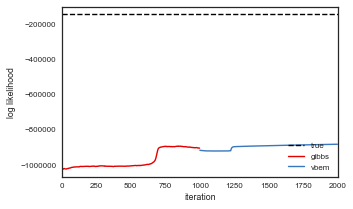

In [85]:
# Plot the log likelihoods
plt.figure(figsize=(5,3))
plt.plot([0, N_gibbs_samples + N_vbem_iters], true_model.log_likelihood() * np.ones(2), '--k', label="true")
plt.plot(np.arange(N_gibbs_samples), gibbs_lls, color=colors[0], label="gibbs")
plt.plot(np.arange(N_gibbs_samples + 1, N_gibbs_samples + N_vbem_iters), vbem_lls[1:], color=colors[1], label="vbem")
plt.xlim(0, N_gibbs_samples + N_vbem_iters)
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("aux/demo_ll.png")

In [87]:
# Smooth the data
smoothed_data = test_model.smooth(unit_trial, inputs=inputs)

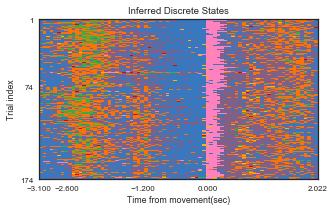

In [130]:
fig = plt.figure(figsize=(5,40))
# gs = GridSpec(3, 1, height_ratios=[.1, .1, 1.0])
ax = fig.add_subplot(gs[1,0])
timeRange = params['timeSeries'][0][0].flatten()
ax.imshow(test_model.states_list[0].stateseq.reshape(numTrial, numTime), vmin=0, vmax=max(len(colors), test_model.num_states)-1,
          cmap=cmap, interpolation="nearest", extent=[timeRange.min(),timeRange.max(),numTrial,1], aspect='auto')
ax.set_xticks([timeRange.min(), -2.6, -1.2, 0,timeRange.max()])
ax.set_yticks([numTrial, totTargets.sum(),1])
ax.set_xlabel('Time from movement(sec)')
ax.set_ylabel('Trial index')
ax.set_title("Inferred Discrete States")
plt.show()

# ax = fig.add_subplot(gs[2,0])
# plt.plot(y[:,0], color='k', lw=2, label="observed")
# plt.plot(smoothed_data[:,0], color=colors[0], lw=1, label="smoothed")
# plt.xlabel("Time")
# plt.xlim(0, min(T, 500))
# plt.ylabel("Observations")
# plt.legend(loc="upper center", ncol=2)
# plt.tight_layout()
# # d
# # 
# plt.figure()
# from pyhsmm.util.general import rle
# z_rle = rle(z)
# offset = 0
# for k, dur in zip(*z_rle):
#     plt.plot(x[offset:offset+dur,0], x[offset:offset+dur,1], color=colors[k])
#     offset += dur

# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.title("Continuous Latent States")
# plt.show()

In [96]:
test_model.states_list[0].stateseq.shape

(13398,)

In [100]:
test_model.num_states

8

In [122]:
timeRange = params['timeSeries'][0][0].flatten()

In [125]:
timeRange.min()

-3.099730458221024